In [1]:
import kagglehub

#path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")

#print("Path to dataset files:", path)

/home/anderson_walsh/UTK/COSC523Project2/nlp/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train = '/home/anderson_walsh/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1/Training'
test = '/home/anderson_walsh/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1/Testing'

In [3]:
import cv2
import numpy as np
import os

DATASET_PATH = '/home/anderson_walsh/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1/'

IMG_SIZE = 224

labels_map = {
    'glioma': 0,
    'meningioma': 1,
    'pituitary': 2,
    'notumor': 3  
}

def load_data(folder):
    X = []
    y = []
    for label in labels_map.keys():
        class_folder = os.path.join(folder, label)
        for img_file in os.listdir(class_folder):
            img_path = os.path.join(class_folder, img_file)
            try:
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
                X.append(img)
                y.append(labels_map[label])
            except:
                print(f"Skipped corrupt image: {img_path}")
    return np.array(X), np.array(y)


In [4]:
X_train, y_train = load_data(os.path.join(DATASET_PATH, 'Training'))

X_test, y_test = load_data(os.path.join(DATASET_PATH, 'Testing'))

print("Training set:", X_train.shape, y_train.shape)
print("Testing set:", X_test.shape, y_test.shape)

Training set: (5712, 224, 224) (5712,)
Testing set: (1311, 224, 224) (1311,)


In [5]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [6]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train, num_classes=4)
y_val = to_categorical(y_val, num_classes=4)
y_test = to_categorical(y_test, num_classes=4)

2025-05-04 18:24:06.358772: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-04 18:24:06.365355: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746397446.372555  432959 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746397446.374814  432959 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-04 18:24:06.382426: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [7]:
import tensorflow as tf
import numpy as np
def data_generator():
    for img, label in zip(X_train, y_train):
        img_array = np.array(img, dtype=np.uint8)
        yield img_array, label
def data_generator_val():
    for img, label in zip(X_val, y_val):
        img_array = np.array(img, dtype=np.uint8)
        yield img_array, label
train_ds = tf.data.Dataset.from_generator(
    data_generator,
    output_signature=(
        tf.TensorSpec(shape=(224, 224), dtype=tf.uint8),
        tf.TensorSpec(shape=(4,), dtype=tf.uint8)
    )
)
val_ds = tf.data.Dataset.from_generator(
    data_generator_val,
    output_signature=(
        tf.TensorSpec(shape=(224, 224), dtype=tf.uint8),
        tf.TensorSpec(shape=(4,), dtype=tf.uint8)
    )
)

I0000 00:00:1746397447.603741  432959 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21458 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:01:00.0, compute capability: 8.9


In [8]:
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomWidth, RandomHeight, RandomZoom


data_augmentation = tf.keras.Sequential([
    RandomRotation(0.2),
    RandomWidth(0.2),
    RandomHeight(0.2),
    RandomZoom(0.2),
])


In [9]:
def preprocess(img, label):
    img = tf.expand_dims(img, axis=-1)
    img = tf.image.grayscale_to_rgb(img)
    img = tf.cast(img, tf.float32) / 255.0
    label = tf.cast(label, tf.float32)
    return img, label
def preprocess_train(img, label):
    img = tf.expand_dims(img, axis=-1)
    img = tf.image.grayscale_to_rgb(img)
    img = tf.cast(img, tf.float32) / 255.0
    #img = data_augmentation(img)
    #img = tf.image.resize(img, (224, 224))
    label = tf.cast(label, tf.float32)
    return img, label

In [10]:
train_ds = (
    train_ds
    .map(preprocess_train, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(32)
    .prefetch(tf.data.AUTOTUNE)
)
val_ds = (
    val_ds
    .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(32)
    .prefetch(tf.data.AUTOTUNE)
)

In [11]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input

inputs = Input(shape=(224, 224, 3))


x = inputs

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

x = base_model(x, training=False)

# Custom classification head
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)
outputs = Dense(4, activation='sigmoid')(x)

model = Model(inputs, outputs)

In [12]:
from tensorflow.keras.metrics import AUC
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
	metrics=['accuracy']
)

In [13]:
from tensorflow.keras import callbacks
early_stop = callbacks.EarlyStopping(patience=5, restore_best_weights=True, min_delta=0.001, monitor='val_accuracy', mode='max')
reduce_lr = callbacks.ReduceLROnPlateau(patience=3, factor=0.5, verbose=1)
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[early_stop]
)

Epoch 1/50


I0000 00:00:1746397451.779559  433117 service.cc:148] XLA service 0x7f7590002030 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746397451.779584  433117 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2025-05-04 18:24:11.878747: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1746397452.385708  433117 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-05-04 18:24:13.166458: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6544_0', 112 bytes spill stores, 224 bytes spill loads

2025-05-04 18:24:13.201317: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_10019', 68 

    142/Unknown 8s 12ms/step - accuracy: 0.2923 - loss: 0.6032

2025-05-04 18:24:17.941966: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6544_0', 8 bytes spill stores, 8 bytes spill loads

2025-05-04 18:24:17.991738: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6544', 16 bytes spill stores, 16 bytes spill loads

2025-05-04 18:24:18.148091: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_10019', 12 bytes spill stores, 16 bytes spill loads

2025-05-04 18:24:18.187657: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_10019', 32 bytes spill stores, 32 bytes spill loads

2025-05-04 18:24:18.187831: I external/local_xla/xla/strea

    143/Unknown 11s 32ms/step - accuracy: 0.2925 - loss: 0.6029

2025-05-04 18:24:20.013981: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-05-04 18:24:20.014028: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2025-05-04 18:24:20.014034: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3053671888699155637
2025-05-04 18:24:20.014037: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6103064488571288724
/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, trace

143/143 ━━━━━━━━━━━━━━━━━━━━ 16s 70ms/step - accuracy: 0.2928 - loss: 0.6027 - val_accuracy: 0.4217 - val_loss: 0.5000
Epoch 2/50


2025-05-04 18:24:25.199693: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.4157 - loss: 0.5076 - val_accuracy: 0.4243 - val_loss: 0.4667
Epoch 3/50
  6/143 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.3740 - loss: 0.4856

2025-05-04 18:24:27.524203: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.4619 - loss: 0.4713 - val_accuracy: 0.5661 - val_loss: 0.4463
Epoch 4/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.5270 - loss: 0.4465 - val_accuracy: 0.6229 - val_loss: 0.4225
Epoch 5/50
  7/143 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5368 - loss: 0.4404

2025-05-04 18:24:31.925533: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


140/143 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5748 - loss: 0.4264

2025-05-04 18:24:33.682963: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3053671888699155637
2025-05-04 18:24:33.682999: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6103064488571288724


143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.5752 - loss: 0.4263 - val_accuracy: 0.6465 - val_loss: 0.3847
Epoch 6/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.6372 - loss: 0.3963 - val_accuracy: 0.6772 - val_loss: 0.3589
Epoch 7/50
139/143 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6589 - loss: 0.3694

2025-05-04 18:24:38.082946: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3053671888699155637
2025-05-04 18:24:38.082982: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6103064488571288724


143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.6587 - loss: 0.3694 - val_accuracy: 0.7069 - val_loss: 0.3392
Epoch 8/50
  3/143 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7066 - loss: 0.3769

2025-05-04 18:24:38.512124: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3053671888699155637
2025-05-04 18:24:38.512235: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6103064488571288724


143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.6781 - loss: 0.3560 - val_accuracy: 0.7192 - val_loss: 0.3235
Epoch 9/50
  6/143 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7256 - loss: 0.3552

2025-05-04 18:24:40.727114: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.6932 - loss: 0.3409 - val_accuracy: 0.7402 - val_loss: 0.3092
Epoch 10/50
142/143 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7080 - loss: 0.3254

2025-05-04 18:24:44.732723: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3053671888699155637
2025-05-04 18:24:44.732753: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6103064488571288724


143/143 ━━━━━━━━━━━━━━━━━━━━ 365s 3s/step - accuracy: 0.7080 - loss: 0.3254 - val_accuracy: 0.7559 - val_loss: 0.3012
Epoch 11/50
  2/143 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7266 - loss: 0.3550

2025-05-04 18:24:46.920624: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3053671888699155637
2025-05-04 18:24:46.920665: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6103064488571288724


143/143 ━━━━━━━━━━━━━━━━━━━━ -360s -2537114us/step - accuracy: 0.7233 - loss: 0.3173 - val_accuracy: 0.7655 - val_loss: 0.2908
Epoch 12/50
140/143 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7230 - loss: 0.3100

2025-05-04 18:24:49.152623: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3053671888699155637
2025-05-04 18:24:49.152660: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6103064488571288724


143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7228 - loss: 0.3101 - val_accuracy: 0.7524 - val_loss: 0.2872
Epoch 13/50
 58/143 ━━━━━━━━━━━━━━━━━━━━ 9:01 6s/step - accuracy: 0.7275 - loss: 0.3033 

2025-05-04 18:24:51.268892: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3053671888699155637
2025-05-04 18:24:51.269167: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6103064488571288724


143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7277 - loss: 0.3047 - val_accuracy: 0.7655 - val_loss: 0.2834
Epoch 14/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7340 - loss: 0.3012 - val_accuracy: 0.7682 - val_loss: 0.2718
Epoch 15/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7472 - loss: 0.2931 - val_accuracy: 0.7769 - val_loss: 0.2673
Epoch 16/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7470 - loss: 0.2904 - val_accuracy: 0.7734 - val_loss: 0.2643
Epoch 17/50
 13/143 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7677 - loss: 0.2775

2025-05-04 18:24:58.278267: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7511 - loss: 0.2845 - val_accuracy: 0.7795 - val_loss: 0.2604
Epoch 18/50
142/143 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7533 - loss: 0.2853

2025-05-04 18:25:02.198174: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3053671888699155637
2025-05-04 18:25:02.198206: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6103064488571288724


143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7533 - loss: 0.2854 - val_accuracy: 0.7857 - val_loss: 0.2596
Epoch 19/50
  7/143 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8068 - loss: 0.2599

2025-05-04 18:25:02.637021: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3053671888699155637
2025-05-04 18:25:02.637077: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6103064488571288724


143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7613 - loss: 0.2760

2025-05-04 18:25:04.416582: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3053671888699155637
2025-05-04 18:25:04.416621: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6103064488571288724


143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7613 - loss: 0.2760 - val_accuracy: 0.7848 - val_loss: 0.2539
Epoch 20/50
 38/143 ━━━━━━━━━━━━━━━━━━━━ 17:09 10s/step - accuracy: 0.7798 - loss: 0.2667

2025-05-04 18:25:06.544953: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3053671888699155637
2025-05-04 18:25:06.544996: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6103064488571288724


143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7607 - loss: 0.2746 - val_accuracy: 0.7970 - val_loss: 0.2521
Epoch 21/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7649 - loss: 0.2726 - val_accuracy: 0.7935 - val_loss: 0.2471
Epoch 22/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7614 - loss: 0.2684 - val_accuracy: 0.7953 - val_loss: 0.2466
Epoch 23/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.7766 - loss: 0.2658 - val_accuracy: 0.8014 - val_loss: 0.2451
Epoch 24/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7724 - loss: 0.2661 - val_accuracy: 0.8023 - val_loss: 0.2411
Epoch 25/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7677 - loss: 0.2701 - val_accuracy: 0.7979 - val_loss: 0.2441
Epoch 26/50
142/143 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7693 - loss: 0.2635

2025-05-04 18:25:19.885396: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3053671888699155637
2025-05-04 18:25:19.885430: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6103064488571288724


143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7693 - loss: 0.2635 - val_accuracy: 0.8066 - val_loss: 0.2394
Epoch 27/50
139/143 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7714 - loss: 0.2621

2025-05-04 18:25:22.132126: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3053671888699155637
2025-05-04 18:25:22.132168: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6103064488571288724


143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7713 - loss: 0.2622 - val_accuracy: 0.8066 - val_loss: 0.2373
Epoch 28/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7705 - loss: 0.2605

2025-05-04 18:25:24.329615: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3053671888699155637
2025-05-04 18:25:24.329656: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6103064488571288724


143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7705 - loss: 0.2605 - val_accuracy: 0.7997 - val_loss: 0.2366
Epoch 29/50
 44/143 ━━━━━━━━━━━━━━━━━━━━ 13:55 8s/step - accuracy: 0.8084 - loss: 0.2432 

2025-05-04 18:25:26.460306: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3053671888699155637
2025-05-04 18:25:26.460343: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6103064488571288724


143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7870 - loss: 0.2528 - val_accuracy: 0.8040 - val_loss: 0.2335
Epoch 30/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7750 - loss: 0.2572

2025-05-04 18:25:28.597087: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3053671888699155637
2025-05-04 18:25:28.597128: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6103064488571288724


143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7750 - loss: 0.2572 - val_accuracy: 0.8110 - val_loss: 0.2323
Epoch 31/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7868 - loss: 0.2519 - val_accuracy: 0.8093 - val_loss: 0.2291
Epoch 32/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7856 - loss: 0.2484

2025-05-04 18:25:32.937871: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3053671888699155637
2025-05-04 18:25:32.937911: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6103064488571288724


143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7856 - loss: 0.2484 - val_accuracy: 0.8128 - val_loss: 0.2325
Epoch 33/50
  6/143 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8201 - loss: 0.2292

2025-05-04 18:25:33.374118: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7797 - loss: 0.2543

2025-05-04 18:25:35.159435: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3053671888699155637
2025-05-04 18:25:35.159472: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6103064488571288724


143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7797 - loss: 0.2544 - val_accuracy: 0.8066 - val_loss: 0.2297
Epoch 34/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7829 - loss: 0.2529 - val_accuracy: 0.8084 - val_loss: 0.2268
Epoch 35/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7837 - loss: 0.2490 - val_accuracy: 0.8093 - val_loss: 0.2302
Epoch 36/50
 40/143 ━━━━━━━━━━━━━━━━━━━━ 15:58 9s/step - accuracy: 0.7798 - loss: 0.2461 

2025-05-04 18:25:41.561499: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3053671888699155637
2025-05-04 18:25:41.561538: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6103064488571288724


143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7802 - loss: 0.2483 - val_accuracy: 0.8189 - val_loss: 0.2261
Epoch 37/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7880 - loss: 0.2448 - val_accuracy: 0.8084 - val_loss: 0.2264
Epoch 38/50
 95/143 ━━━━━━━━━━━━━━━━━━━━ 3:05 4s/step - accuracy: 0.7902 - loss: 0.2459

2025-05-04 18:25:45.893132: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3053671888699155637
2025-05-04 18:25:45.893171: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6103064488571288724


143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7886 - loss: 0.2470 - val_accuracy: 0.8084 - val_loss: 0.2249
Epoch 39/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7859 - loss: 0.2486 - val_accuracy: 0.8171 - val_loss: 0.2225
Epoch 40/50
141/143 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7844 - loss: 0.2422

2025-05-04 18:25:50.166967: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3053671888699155637
2025-05-04 18:25:50.167004: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6103064488571288724


143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7843 - loss: 0.2423 - val_accuracy: 0.8145 - val_loss: 0.2241
Epoch 41/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7941 - loss: 0.2452 - val_accuracy: 0.8189 - val_loss: 0.2225


In [14]:
#model.save("cnn_resnet_freeze.keras")
#model = load_model("cnn_resnet_freeze.keras")
classifier_head_weights = [layer.get_weights() for layer in model.layers[-8:]]

In [15]:
from tensorflow.keras.models import load_model
#model = load_model("cnn_80_pretune.keras")

In [ ]:
base_model.trainable = True

for layer in base_model.layers[:-80]:
    layer.trainable = False

In [17]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6),
    loss='binary_crossentropy',
	metrics=['accuracy']
)

In [18]:
for i, layer in enumerate(model.layers[-8:]):
    layer.set_weights(classifier_head_weights[i])

In [19]:

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[reduce_lr]
)

Epoch 1/50


2025-05-04 18:26:01.627574: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_12169', 104 bytes spill stores, 104 bytes spill loads



143/143 ━━━━━━━━━━━━━━━━━━━━ 25s 85ms/step - accuracy: 0.3800 - loss: 4.2801 - val_accuracy: 0.2773 - val_loss: 4.3315 - learning_rate: 1.0000e-06
Epoch 2/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.5674 - loss: 1.0729 - val_accuracy: 0.2852 - val_loss: 3.2377 - learning_rate: 1.0000e-06
Epoch 3/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.6915 - loss: 0.6339 - val_accuracy: 0.7095 - val_loss: 0.4746 - learning_rate: 1.0000e-06
Epoch 4/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.7306 - loss: 0.4486 - val_accuracy: 0.7638 - val_loss: 0.3708 - learning_rate: 1.0000e-06
Epoch 5/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.7739 - loss: 0.3566 - val_accuracy: 0.7979 - val_loss: 0.3261 - learning_rate: 1.0000e-06
Epoch 6/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.7939 - loss: 0.3126 - val_accuracy: 0.8119 - val_loss: 0.2909 - learning_rate: 1.0000e-06
Epoch 7/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.8

2025-05-04 18:27:38.778069: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


143/143 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.9829 - loss: 0.0367 - val_accuracy: 0.8898 - val_loss: 0.2060 - learning_rate: 5.0000e-07
Epoch 25/50
137/143 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 0.9846 - loss: 0.0362
Epoch 25: ReduceLROnPlateau reducing learning rate to 2.499999993688107e-07.
143/143 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.9848 - loss: 0.0361 - val_accuracy: 0.8854 - val_loss: 0.2089 - learning_rate: 5.0000e-07
Epoch 26/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.9870 - loss: 0.0334 - val_accuracy: 0.8933 - val_loss: 0.2046 - learning_rate: 2.5000e-07
Epoch 27/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.9855 - loss: 0.0317 - val_accuracy: 0.8941 - val_loss: 0.2037 - learning_rate: 2.5000e-07
Epoch 28/50
142/143 ━━━━━━━━━━━━━━━━━━━━ 2s 3s/step - accuracy: 0.9904 - loss: 0.0265 
Epoch 28: ReduceLROnPlateau reducing learning rate to 1.2499999968440534e-07.
143/143 ━━━━━━━━━━━━━━━━━━━━ 366s 3s/step - accuracy: 0.9904 - 

In [20]:
model.save("cnn_resnet_unfreeze.keras")
from tensorflow.keras.models import load_model
#model = load_model("cnn_resnet_unfreeze.keras")

In [21]:
test_ds = tf.data.Dataset.from_generator(
    data_generator_val,
    output_signature=(
        tf.TensorSpec(shape=(224, 224), dtype=tf.uint8),
        tf.TensorSpec(shape=(4,), dtype=tf.uint8)
    )
)
test_ds = (
   	test_ds 
    .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(32)
    .prefetch(tf.data.AUTOTUNE)
)

36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


CNN Accuracy: 0.9011


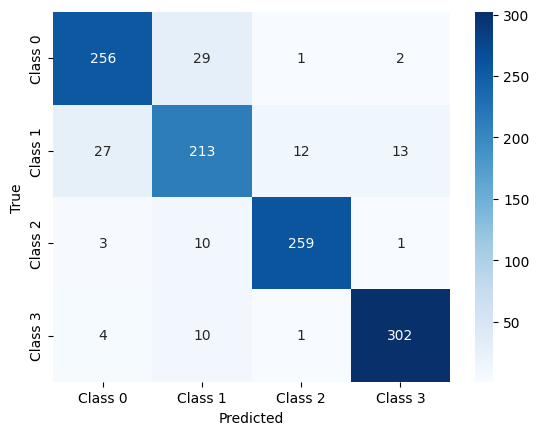

In [27]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = model.predict(test_ds)

y_true = []
for _, label_batch in test_ds:
    y_true.append(label_batch.numpy())

y_true = np.concatenate(y_true, axis=0)

y_true = np.argmax(y_true, axis=1)

y_pred = np.argmax(y_pred, axis=1)

acc = accuracy_score(y_true, y_pred)
print(f"CNN Accuracy: {acc:.4f}")

conf_matrix = confusion_matrix(y_true, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Class 0", "Class 1", "Class 2", "Class 3"], yticklabels=["Class 0", "Class 1", "Class 2", "Class 3"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [28]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
acc = accuracy_score(y_true, y_pred)
print(f"CNN Accuracy: {acc:.4f}")

precision = precision_score(y_true, y_pred, average=None)  # per class precision
recall = recall_score(y_true, y_pred, average=None)  # per class recall
f1 = f1_score(y_true, y_pred, average=None)  # per class f1 score

print("Precision (per class):", precision)
print("Recall (per class):", recall)
print("F1 Score (per class):", f1)

precision_macro = precision_score(y_true, y_pred, average='macro')
recall_macro = recall_score(y_true, y_pred, average='macro')
f1_macro = f1_score(y_true, y_pred, average='macro')

print("\nOverall (macro average) Precision:", precision_macro)
print("Overall (macro average) Recall:", recall_macro)
print("Overall (macro average) F1 Score:", f1_macro)

report = classification_report(y_true, y_pred, target_names=["glioma", "meningioma", "pituitary", "notumor"])
print("\nClassification Report:\n", report)

CNN Accuracy: 0.9011
Precision (per class): [0.88275862 0.8129771  0.94871795 0.94968553]
Recall (per class): [0.88888889 0.80377358 0.94871795 0.95268139]
F1 Score (per class): [0.88581315 0.80834915 0.94871795 0.9511811 ]

Overall (macro average) Precision: 0.8985348008088601
Overall (macro average) Recall: 0.898515452631279
Overall (macro average) F1 Score: 0.8985153364947844

Classification Report:
               precision    recall  f1-score   support

      glioma       0.88      0.89      0.89       288
  meningioma       0.81      0.80      0.81       265
   pituitary       0.95      0.95      0.95       273
     notumor       0.95      0.95      0.95       317

    accuracy                           0.90      1143
   macro avg       0.90      0.90      0.90      1143
weighted avg       0.90      0.90      0.90      1143



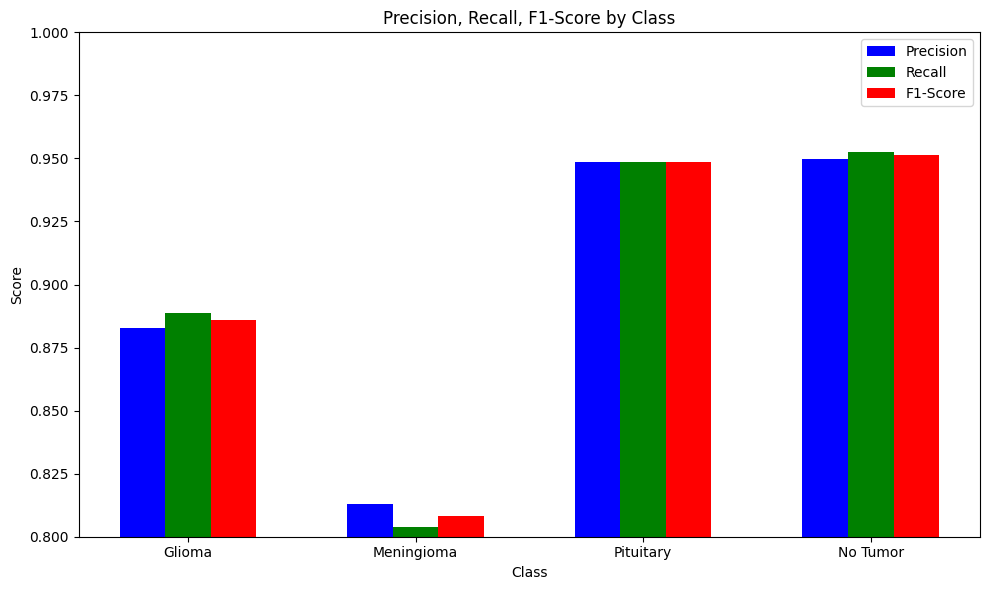

In [29]:
precision = [0.88275862, 0.8129771,  0.94871795, 0.94968553]
recall = [0.88888889, 0.80377358, 0.94871795, 0.95268139,]
f1_score = [0.88581315, 0.80834915, 0.94871795, 0.9511811]

classes = ['Glioma', 'Meningioma', 'Pituitary', 'No Tumor']

bar_width = 0.2
index = np.arange(len(classes))

fig, ax = plt.subplots(figsize=(10, 6))

bar1 = ax.bar(index, precision, bar_width, label='Precision', color='blue')
bar2 = ax.bar(index + bar_width, recall, bar_width, label='Recall', color='green')
bar3 = ax.bar(index + 2 * bar_width, f1_score, bar_width, label='F1-Score', color='red')


ax.set_ylim(0.8, 1)
ax.set_xlabel('Class')
ax.set_ylabel('Score')
ax.set_title('Precision, Recall, F1-Score by Class')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(classes)
ax.legend()

plt.tight_layout()
plt.show()

In [25]:
import importlib.util
import subprocess

# --- Install pushbullet.py if it's not already present ---
if importlib.util.find_spec("pushbullet") is None:
    subprocess.run(["pip", "install", "pushbullet.py"])

# --- Pushbullet notification ---
try:
    from pushbullet import Pushbullet
    pb = Pushbullet("o.Dgrk9aBAsSvb3dJSzNaJlHJa7y5wv9R2")  # ⬅️ Replace with your real API key
    pb.push_note("✅ Training Complete", "Your notebook has finished running.")
    print("Pushbullet notification sent.")
except Exception as e:
    print("Pushbullet notification failed:", e)

Pushbullet notification sent.
